In [1]:
# Helper functions
from notebooks.util.distribution_utils import *

from liquidity.util.utils import compute_returns, get_agg_features
from hurst_exponent.util.utils import augmented_dickey_fuller

In [2]:
# Automatically reload changes in package dependencies
%load_ext autoreload
%autoreload 2

In [3]:
# Number of events to use
EVENTS_RANGE = 100000

# Window/bin size for computing imbalances
T = 100

## Load raw sample data

In [4]:
# Load raw sample data  from CSV
stocks = ['TSLA', 'AMZN', 'NFLX', 'MSFT', 'EBAY', 'APPL']

current_dir = os.path.abspath('.')
root_dir = os.path.join(current_dir, '..', '..')
data_dir = os.path.join(root_dir, 'data', 'market_orders')

stock_dfs = {}

# Loop through each stock
for stock in stocks:

    filename = f"{stock}-2016-R1.csv"

    stock_file_path = os.path.join(data_dir, filename)

    # Read the CSV and store in the dictionary
    stock_dfs[stock] = pd.read_csv(stock_file_path)

# Access the dataframe using stock's ticker as key
tsla_raw_df = stock_dfs['TSLA']
amzn_raw_df = stock_dfs['AMZN']
nflx_raw_df = stock_dfs['NFLX']
msft_raw_df = stock_dfs['MSFT']
ebay_raw_df = stock_dfs['EBAY']
appl_raw_df = stock_dfs['APPL']

## 1. Return magnitudes

In [5]:
# Return magnitude (volatility)
tsla_returns = compute_returns(tsla_raw_df)['returns']
msft_returns = compute_returns(msft_raw_df)['returns']
amzn_returns = compute_returns(amzn_raw_df)['returns']
nflx_returns = compute_returns(nflx_raw_df)['returns']
ebay_returns = compute_returns(ebay_raw_df)['returns']
appl_returns = compute_returns(appl_raw_df)['returns']

return_magnitudes = {
  'TSLA': abs(tsla_returns),
  'MSFT': abs(msft_returns),
  'AMZN': abs(amzn_returns),
  'NFLX': abs(nflx_returns),
  'EBAY': abs(ebay_returns),
  'APPL': abs(appl_returns)
}

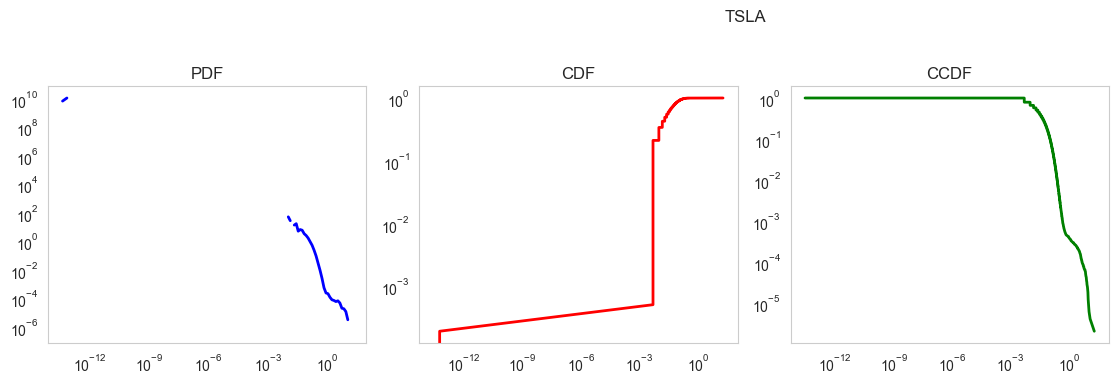

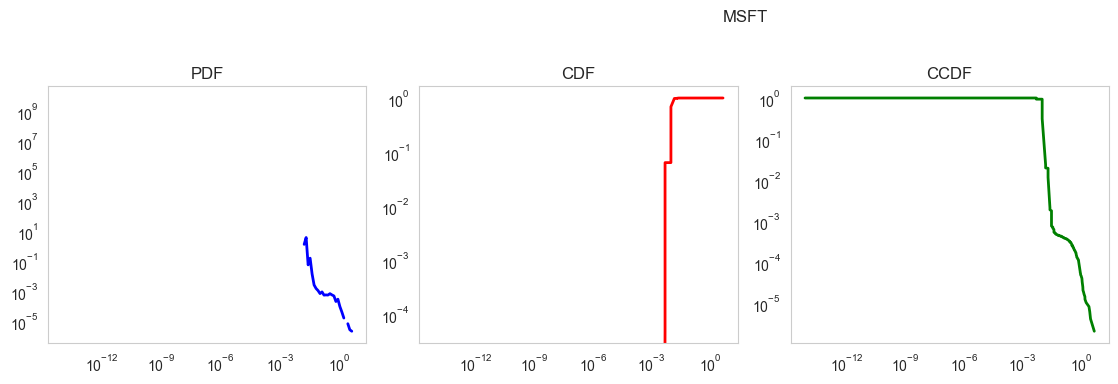

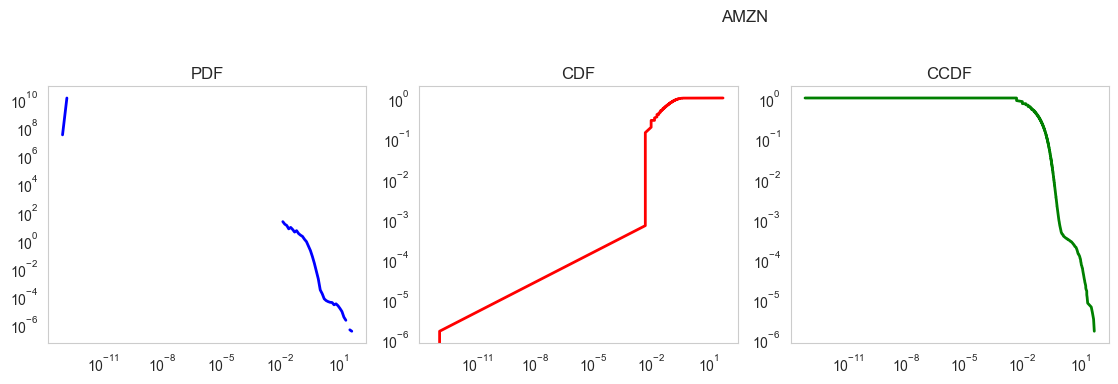

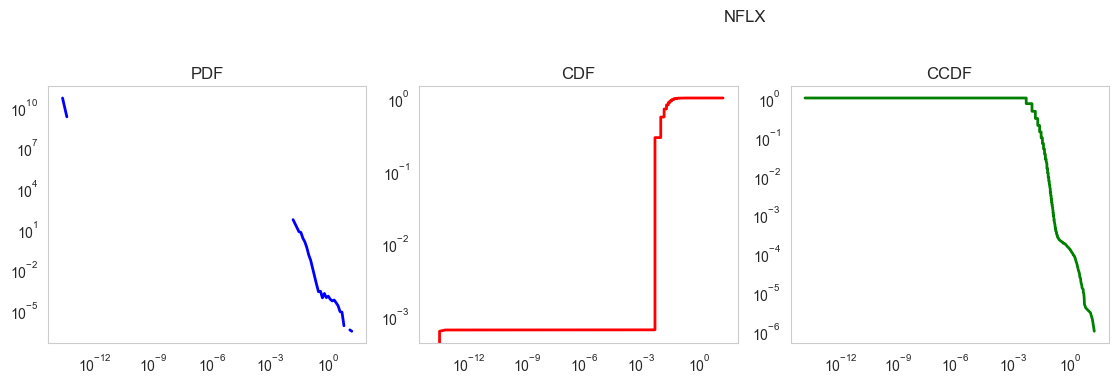

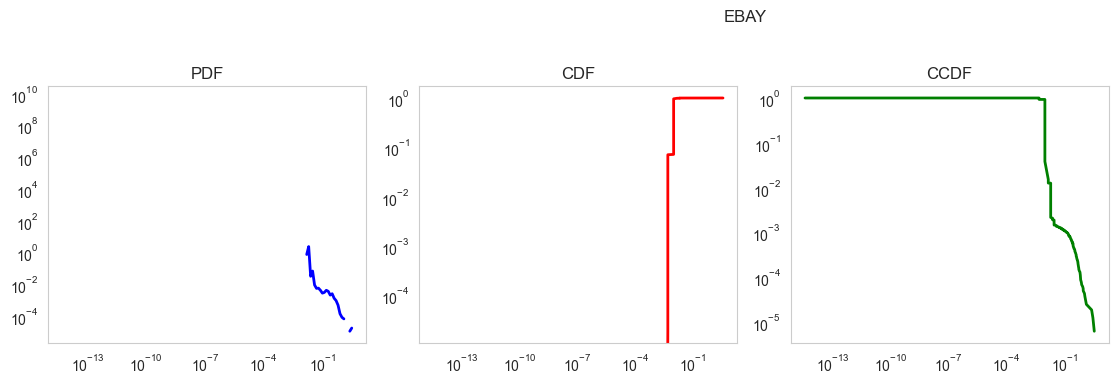

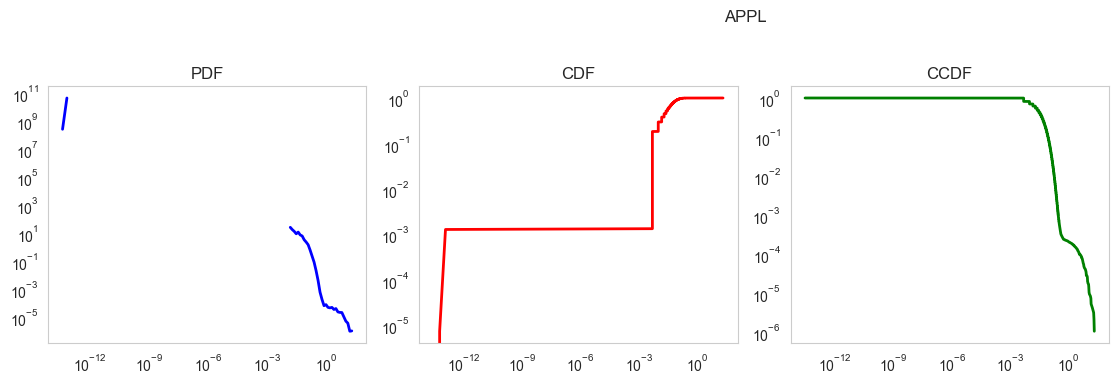

In [6]:
# Plot distribution of returns_magnitudes for each stock
for stock_name, data in return_magnitudes.items():
    plot_distributions(stock_name, data)

### Stationarity Test

In [7]:
# ADF test
for stock, data in return_magnitudes.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -29.68
p-value: 0.00,
N: 99931, 
critical values: {'1%': -3.4304154398333235, '5%': -2.861568923380865, '10%': -2.5667853949035773}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -42.01
p-value: 0.00,
N: 99957, 
critical values: {'1%': -3.43041542281121, '5%': -2.861568915857441, '10%': -2.5667853908991076}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -36.67
p-value: 0.00,
N: 99945, 
critical values: {'1%': -3.4304154306664696, '5%': -2.8615689193293044, '10%': -2.5667853927470654}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -30.86
p-value: 0.00,
N: 99932, 
critical values: {'1%': -3.430415439178463, '5%': -2.8615689230914305, '10%': -2.566785394749521}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


EBAY
A

#### 1.2. Fit power law distribution

In [8]:
# 1. Fit Powerlaw and retrieve fitted object/ results
volatility_data = os.path.join(root_dir, 'data', 'generated', 'mo_data', 'mo_volatility_distributions.pkl')

# If the file doesn't exist, fit the series and save the results.
if not os.path.exists(volatility_data):
    volatility_fit_objects = fit_powerlaw(return_magnitudes, volatility_data)
else:
    volatility_fit_objects = load_fit_objects(volatility_data)

volatility_fit_objects

{'TSLA': <powerlaw.Fit at 0x30a72ca10>,
 'MSFT': <powerlaw.Fit at 0x30b720bd0>,
 'AMZN': <powerlaw.Fit at 0x30b39c450>,
 'NFLX': <powerlaw.Fit at 0x32aebbed0>,
 'EBAY': <powerlaw.Fit at 0x30b88e710>,
 'APPL': <powerlaw.Fit at 0x30bb06c10>}

/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
/Users/ana_bug

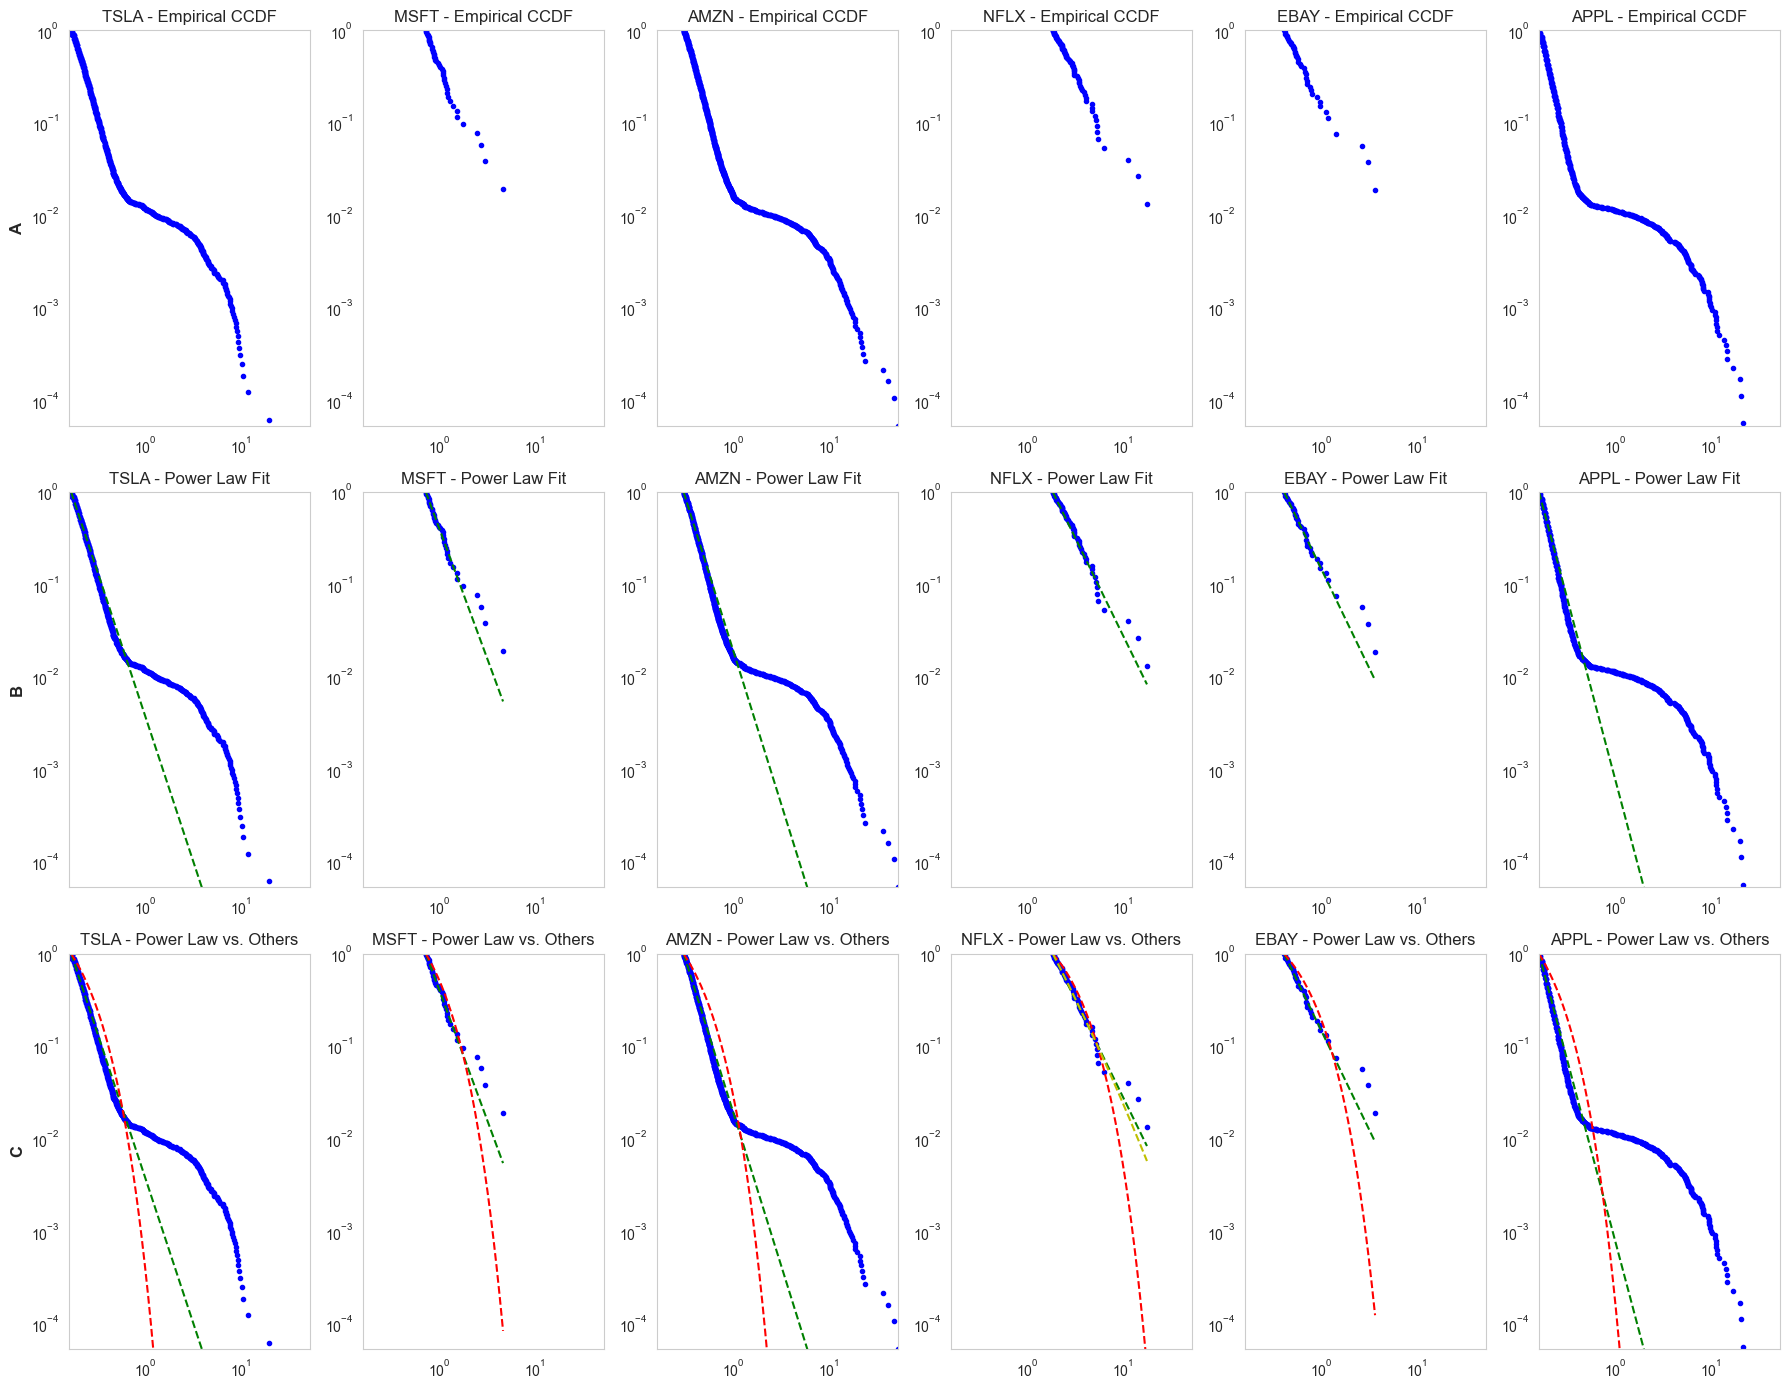

In [9]:
# Plot fitted objects
plot_fit_objects(volatility_fit_objects)

#### 1.3. Retrieve Power law fitting results

In [10]:
# Get fitting parameters for specific distribution across all stocks
volatility_fit_results = get_fitting_params(volatility_fit_objects, 'power_law')
print(volatility_fit_results)

  Stock Distribution     alpha   xmin  KS Distance
0  TSLA    power_law  4.130333  0.170     0.046624
1  MSFT    power_law  3.806991  0.730     0.054107
2  AMZN    power_law  4.308238  0.305     0.032523
3  NFLX    power_law  3.113174  1.855     0.055235
4  EBAY    power_law  3.139655  0.410     0.052937
5  APPL    power_law  4.901875  0.160     0.056475


In [11]:
# Average Alpha exponents across stocks
min_alpha = volatility_fit_results['alpha'].min()
max_alpha = volatility_fit_results['alpha'].max()
avg_alpha = volatility_fit_results['alpha'].mean()
std_dev_alpha = volatility_fit_results['alpha'].std()

print(f"Min Alpha: {min_alpha}")
print(f"Max Alpha: {max_alpha}")
print(f"Average Alpha: {avg_alpha}")
print(f"std_dev_alpha: {std_dev_alpha}")

Min Alpha: 3.1131743625399455
Max Alpha: 4.901875009697774
Average Alpha: 3.9000444662884894
std_dev_alpha: 0.6970414883962968


#### 1.4. Compare alternative distributions

In [12]:
# Compare against alternative heavy-tailed distributions
from IPython.display import display
volatility_comparison = distribution_compare(volatility_fit_objects, 'exponential')
display(volatility_comparison)

,Stock,Alternative Distribution,Lambda,xmin,Power Law Alpha,KS Distance (Power Law),KS Distance (exponential),Loglikelihood Ratio,p-value
0,TSLA,exponential,9.332323,0.170,4.130333,0.046624,0.204073,13.297164,2.404141e-40
1,MSFT,exponential,2.381483,0.730,3.806991,0.054107,0.163922,1.880817,5.999684e-02
2,AMZN,exponential,5.044501,0.305,4.308238,0.032523,0.235781,13.609300,3.526051e-42
3,NFLX,exponential,0.642562,1.855,3.113174,0.055235,0.120930,1.398784,1.618777e-01
4,EBAY,exponential,2.771269,0.410,3.139655,0.052937,0.171475,2.106569,3.515495e-02
5,APPL,exponential,10.325328,0.160,4.901875,0.056475,0.295971,15.457821,6.682128e-54


## 2. Orderflow

### 2.3. Signed Volume

In [ ]:
# Signed Volume
signed_volume = {
  'TSLA': tsla_raw_df['norm_trade_volume'] * tsla_raw_df['trade_sign'],
  'MSFT': msft_raw_df['norm_trade_volume'] * msft_raw_df['trade_sign'],
  'AMZN': amzn_raw_df['norm_trade_volume'] * amzn_raw_df['trade_sign'],
  'NFLX': nflx_raw_df['norm_trade_volume'] * nflx_raw_df['trade_sign'],
  'EBAY': ebay_raw_df['norm_trade_volume'] * ebay_raw_df['trade_sign'],
  'APPL': appl_raw_df['norm_trade_volume'] * appl_raw_df['trade_sign']
}
# Update the dictionary to only keep the first EVENTS_RANGE items
# signed_volume = {stock: data.head(EVENTS_RANGE) for stock, data in signed_volume.items()}

In [ ]:
# Plot distribution of signed_volume for each stock
for stock_name, data in signed_volume.items():
    plot_distributions(stock_name, data)

#### Stationarity Test

In [ ]:
# ADF test
for stock, data in signed_volume.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

#### 2.2. Fit power law distribution

In [ ]:
# 1. Fit Powerlaw and retrieve fitted object/ results
signed_volume_data = os.path.join(root_dir, 'data', 'generated', 'mo_data', 'mo_signed_volume_distributions.pkl')

# If the file doesn't exist, fit the series and save the results.
if not os.path.exists(signed_volume_data):
    volume_fit_objects = fit_powerlaw(signed_volume, signed_volume_data)
else:
    volume_fit_objects = load_fit_objects(signed_volume_data)

volume_fit_objects

In [ ]:
# Plot fitted objects
plot_fit_objects(volume_fit_objects)

#### 2.3. Retrieve Power law fitting results

In [ ]:
# Get fitting parameters for specific distribution across all stocks
volume_fit_results = get_fitting_params(volume_fit_objects, 'power_law')
print(volume_fit_results)

In [ ]:
# Average Alpha exponents across stocks
min_alpha = volume_fit_results['alpha'].min()
max_alpha = volume_fit_results['alpha'].max()
avg_alpha = volume_fit_results['alpha'].mean()
std_dev_alpha = volume_fit_results['alpha'].std()

print(f"Min Alphaa: {min_alpha}")
print(f"Max Alphaa: {max_alpha}")
print(f"Average Alpha: {avg_alpha}")
print(f"std_dev_alpha: {std_dev_alpha}")

#### 1.4. Compare alternative distributions

In [ ]:
# Compare against alternative heavy-tailed distributions
from IPython.display import display
volume_comparison = distribution_compare(volatility_fit_objects, 'exponential')
display(volume_comparison)

## 3. Signed Ordeflow Imbalance

In [13]:
# Aggregate orderflow
tsla_aggregate_orderflow = get_agg_features(tsla_raw_df, [T], remove_outliers=False)
msft_aggregate_orderflow = get_agg_features(msft_raw_df, [T], remove_outliers=False)
amzn_aggregate_orderflow = get_agg_features(amzn_raw_df, [T], remove_outliers=False)
nflx_aggregate_orderflow = get_agg_features(nflx_raw_df, [T],remove_outliers=False)
ebay_aggregate_orderflow = get_agg_features(ebay_raw_df, [T], remove_outliers=False)
appl_aggregate_orderflow = get_agg_features(appl_raw_df, [T],remove_outliers=False)

# Returns

# Order Sign imbalance
sign_imbalance = {
  'TSLA': tsla_aggregate_orderflow['sign_imbalance'],
  'MSFT': msft_aggregate_orderflow['sign_imbalance'],
  'AMZN': amzn_aggregate_orderflow['sign_imbalance'],
  'NFLX': nflx_aggregate_orderflow['sign_imbalance'],
  'EBAY': ebay_aggregate_orderflow['sign_imbalance'],
  'APPL': appl_aggregate_orderflow['sign_imbalance']
}

# Sign Volume Imbalance
volume_imbalance = {
 'TSLA': tsla_aggregate_orderflow['vol_imbalance'],
 'MSFT': msft_aggregate_orderflow['vol_imbalance'],
 'AMZN': amzn_aggregate_orderflow['vol_imbalance'],
 'NFLX': nflx_aggregate_orderflow['vol_imbalance'],
 'EBAY': ebay_aggregate_orderflow['vol_imbalance'],
 'APPL': appl_aggregate_orderflow['vol_imbalance']
}

### Stationarity Test

In [14]:
# sign_imbalance ADF test
print('Order-sign Imbalance')
for stock, data in sign_imbalance.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)
print('\n')

# volume_imbalance ADF test
print('Signed-volume Imbalance')
for stock, data in volume_imbalance.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

Order-sign Imbalance
TSLA
ADF: -11.33
p-value: 0.00,
N: 7552, 
critical values: {'1%': -3.431216197578816, '5%': -2.861922794140392, '10%': -2.5669737568795616}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -15.03
p-value: 0.00,
N: 15247, 
critical values: {'1%': -3.4307789631586263, '5%': -2.8617295833846796, '10%': -2.5668709106206444}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -18.18
p-value: 0.00,
N: 10140, 
critical values: {'1%': -3.4309950647136693, '5%': -2.8618250806650556, '10%': -2.5669217432960254}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -15.57
p-value: 0.00,
N: 16290, 
critical values: {'1%': -3.4307514936002126, '5%': -2.861717443834558, '10%': -2.566864448891165}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to b

### 3.2. Order Sign Imbalance

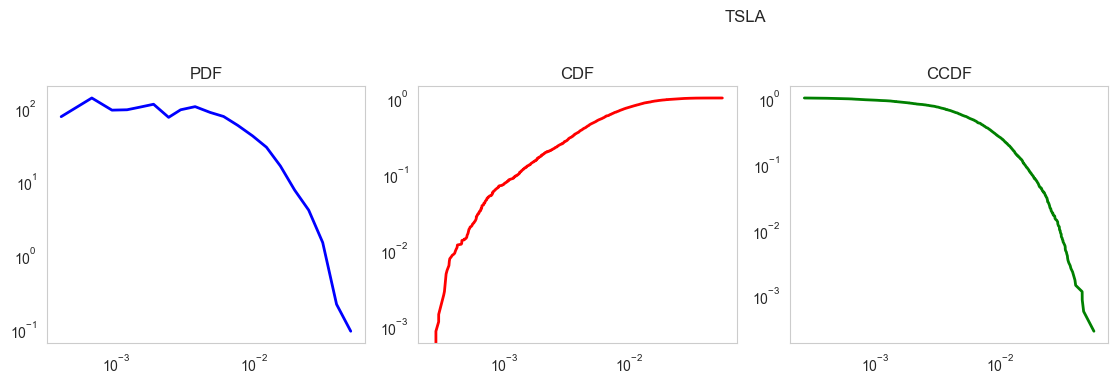

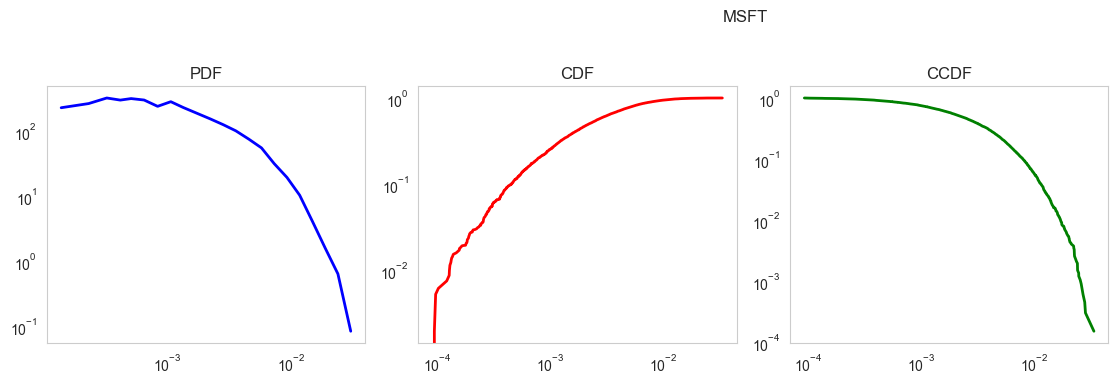

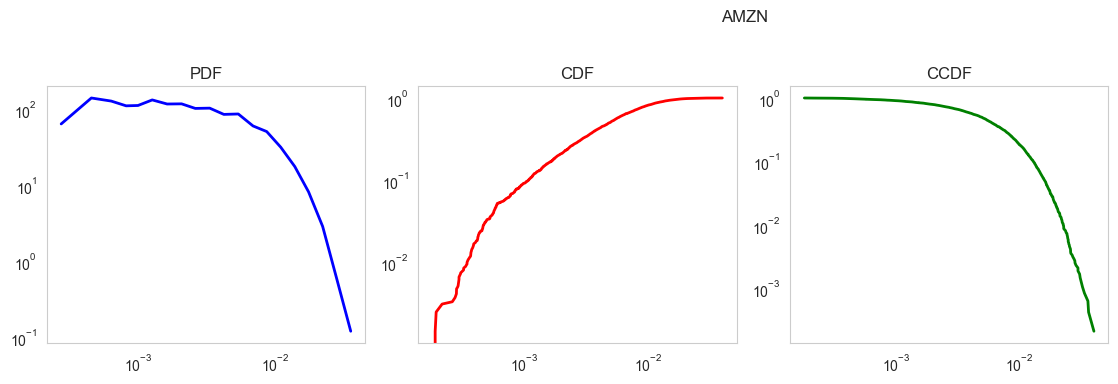

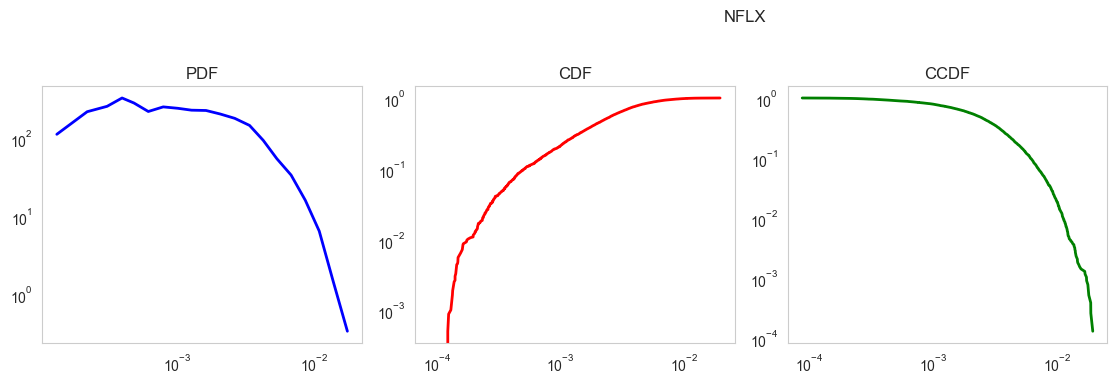

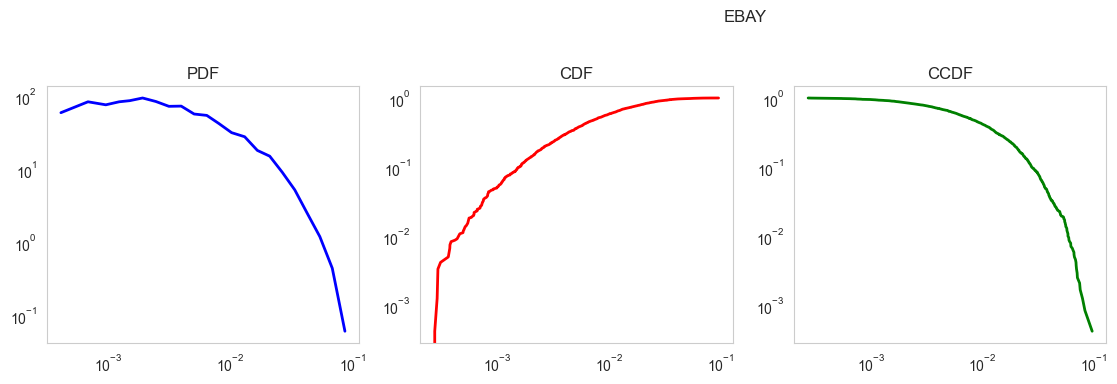

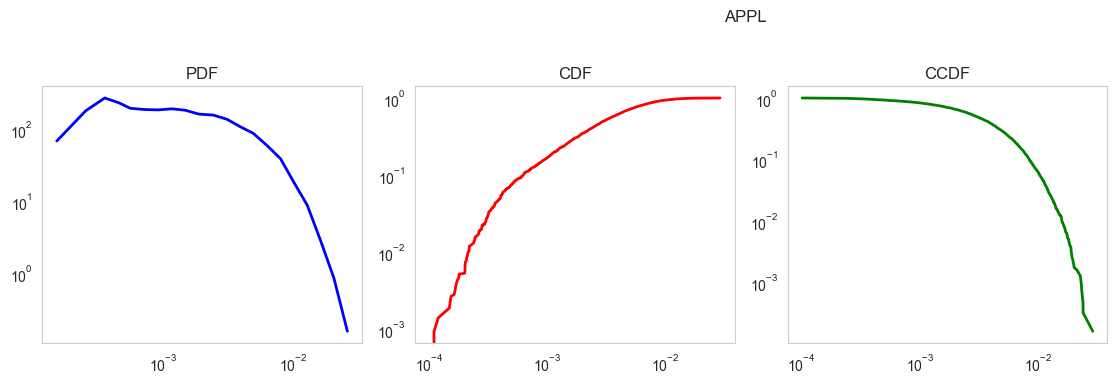

In [15]:
# Plot distribution of sign_imbalance for each stock
for stock_name, data in sign_imbalance.items():
    plot_distributions(stock_name, data)

#### 3.2.1. Fit power law distribution

In [16]:
# 1. Fit Powerlaw and retrieve fitted object/ results
sign_imbalance_data = os.path.join(root_dir, 'data', 'generated', 'mo_data', 'mo_sign_imbalance_distributions.pkl')

# If the file doesn't exist, fit the series and save the results.
if not os.path.exists(sign_imbalance_data):
    sign_imbalance_fit_objects = fit_powerlaw(sign_imbalance, sign_imbalance_data)
else:
    sign_imbalance_fit_objects = load_fit_objects(sign_imbalance_data)

sign_imbalance_fit_objects

{'TSLA': <powerlaw.Fit at 0x30b3b4a10>,
 'MSFT': <powerlaw.Fit at 0x16c2a8490>,
 'AMZN': <powerlaw.Fit at 0x30b56d890>,
 'NFLX': <powerlaw.Fit at 0x30a875150>,
 'EBAY': <powerlaw.Fit at 0x30a875a50>,
 'APPL': <powerlaw.Fit at 0x30a807a50>}

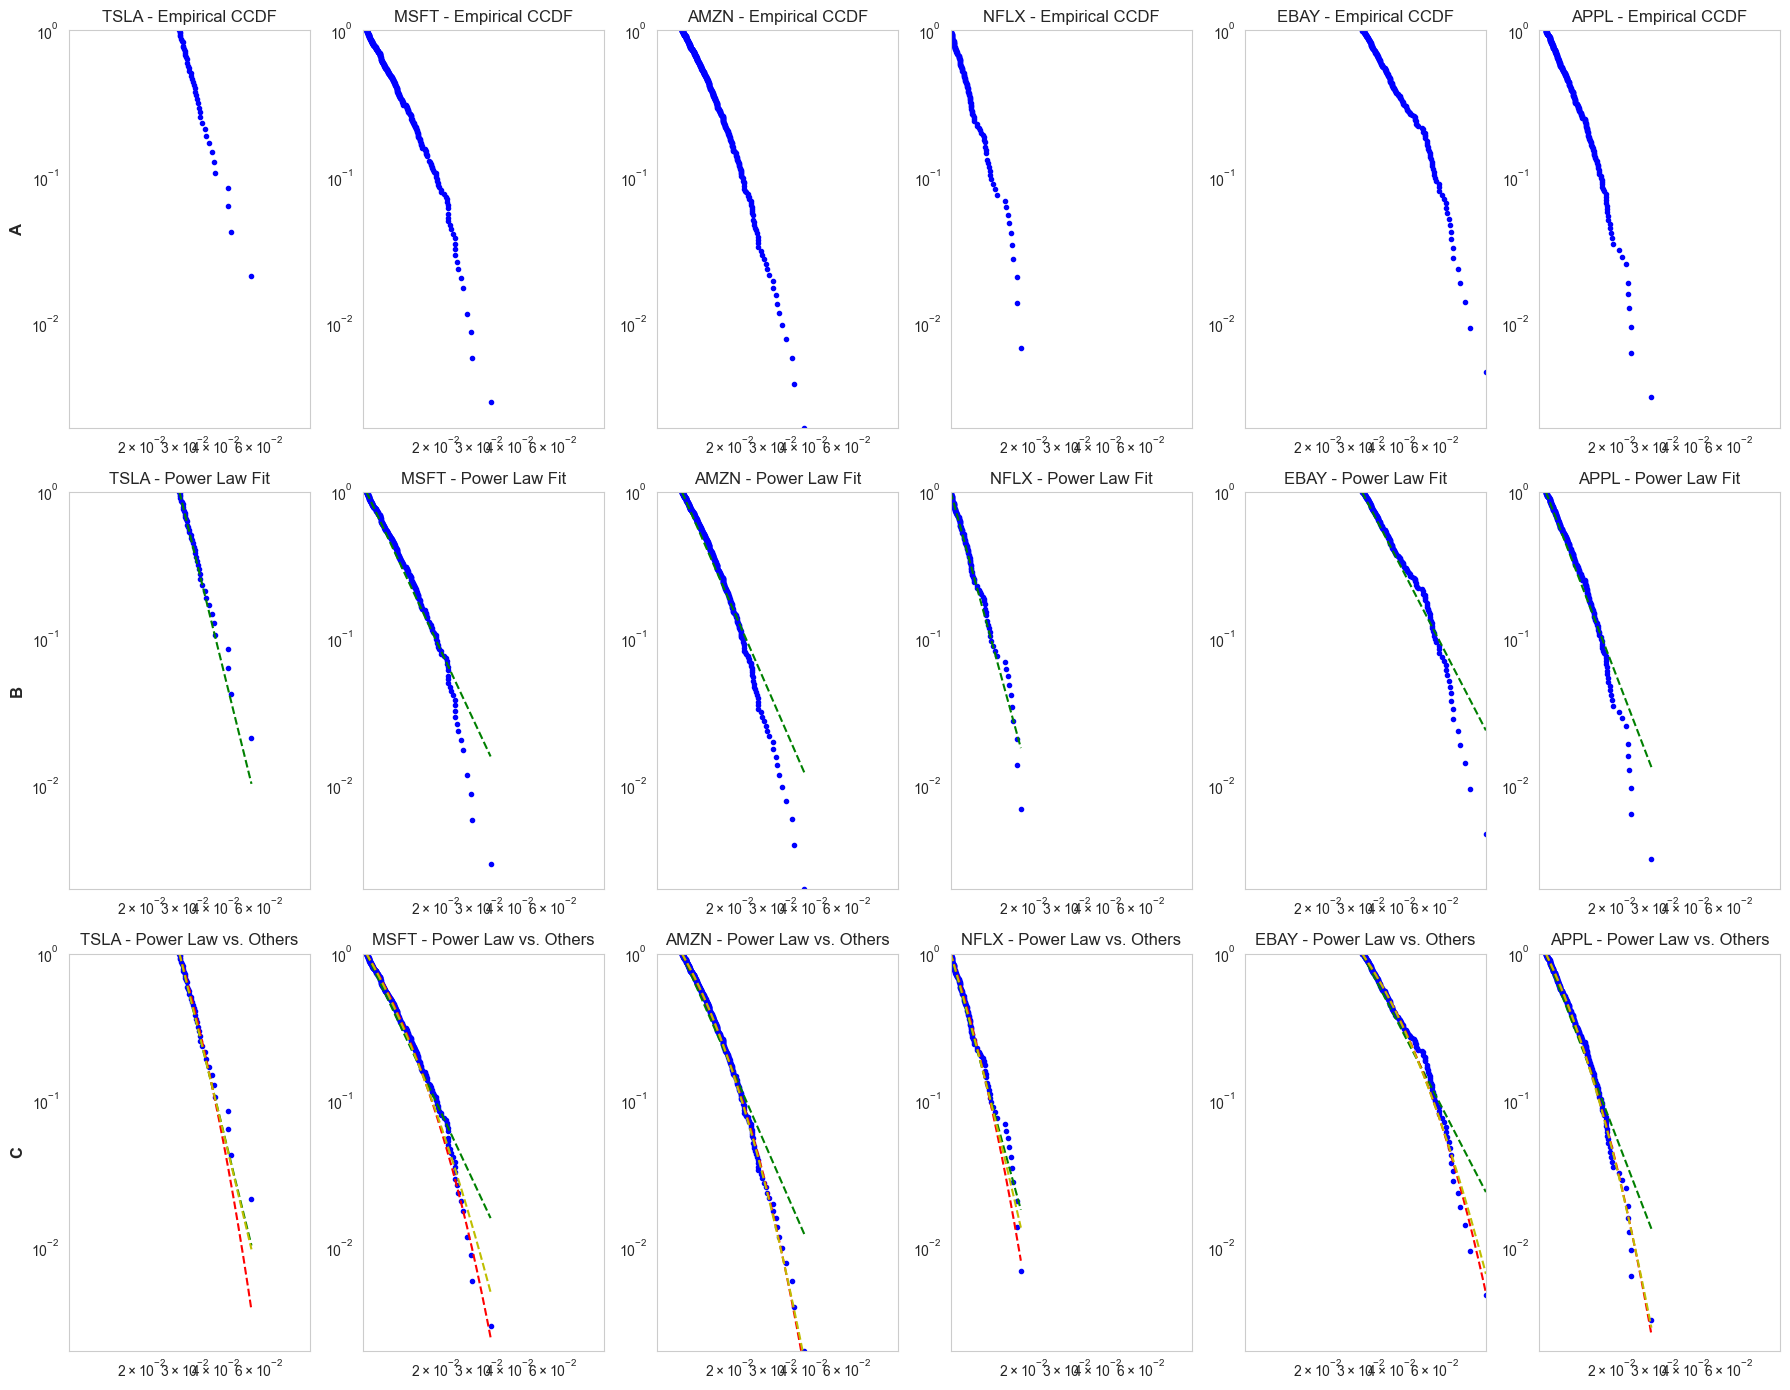

In [17]:
# Plot fitted objects
plot_fit_objects(sign_imbalance_fit_objects)

#### 3.2.2 Retrieve Power law fitting results

In [18]:
# Get fitting parameters for specific distribution across all stocks
sign_imbalance_fit_results = get_fitting_params(sign_imbalance_fit_objects, 'power_law')
print(sign_imbalance_fit_results)

  Stock Distribution     alpha      xmin  KS Distance
0  TSLA    power_law  7.770483  0.028571     0.046473
1  MSFT    power_law  4.561284  0.010479     0.052605
2  AMZN    power_law  4.833541  0.012812     0.061529
3  NFLX    power_law  7.105205  0.010106     0.042147
4  EBAY    power_law  4.218526  0.030334     0.054164
5  APPL    power_law  5.359118  0.010794     0.050624


In [19]:
# Average Alpha exponents across stocks
min_alpha = sign_imbalance_fit_results['alpha'].min()
max_alpha = sign_imbalance_fit_results['alpha'].max()
avg_alpha = sign_imbalance_fit_results['alpha'].mean()
std_dev_alpha = sign_imbalance_fit_results['alpha'].std()

print(f"Min Alpha: {min_alpha}")
print(f"Max Alpha: {max_alpha}")
print(f"Average Alpha: {avg_alpha}")
print(f"std_dev_alpha: {std_dev_alpha}")

Min Alpha: 4.218526081451033
Max Alpha: 7.7704829977931995
Average Alpha: 5.641359386405543
std_dev_alpha: 1.4559712507352809


#### 3.2.3 Compare alternative distributions

In [20]:
# Compare against alternative heavy-tailed distributions
from IPython.display import display
sign_imbalance_comparison = distribution_compare(sign_imbalance_fit_objects, 'exponential')
display(sign_imbalance_comparison)

,Stock,Alternative Distribution,Lambda,xmin,Power Law Alpha,KS Distance (Power Law),KS Distance (exponential),Loglikelihood Ratio,p-value
0,TSLA,exponential,202.719187,0.028571,7.770483,0.046473,0.053800,0.484972,0.627696
1,MSFT,exponential,260.708010,0.010479,4.561284,0.052605,0.041140,-1.670737,0.094774
2,AMZN,exponential,236.253201,0.012812,4.833541,0.061529,0.019998,-3.364393,0.000767
3,NFLX,exponential,512.206706,0.010106,7.105205,0.042147,0.061623,0.133357,0.893911
4,EBAY,exponential,79.995786,0.030334,4.218526,0.054164,0.058655,-2.363414,0.018107
5,APPL,exponential,327.544583,0.010794,5.359118,0.050624,0.037819,-2.503812,0.012286


### 3.3. Volume Imbalance

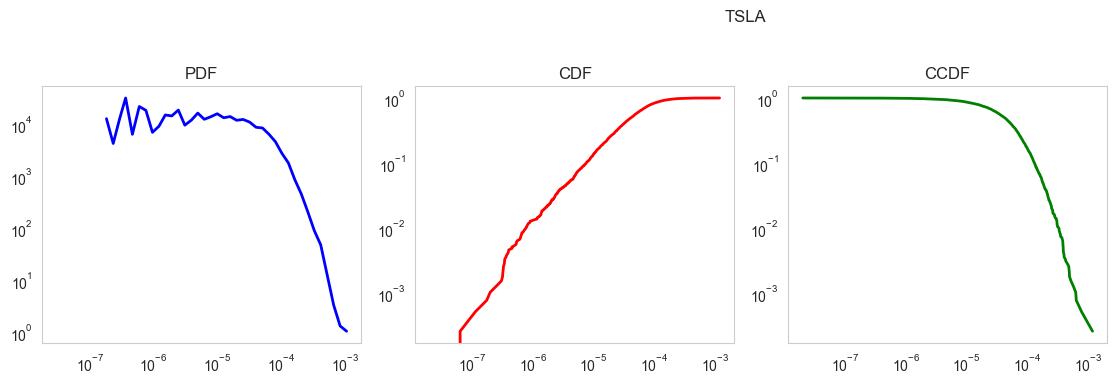

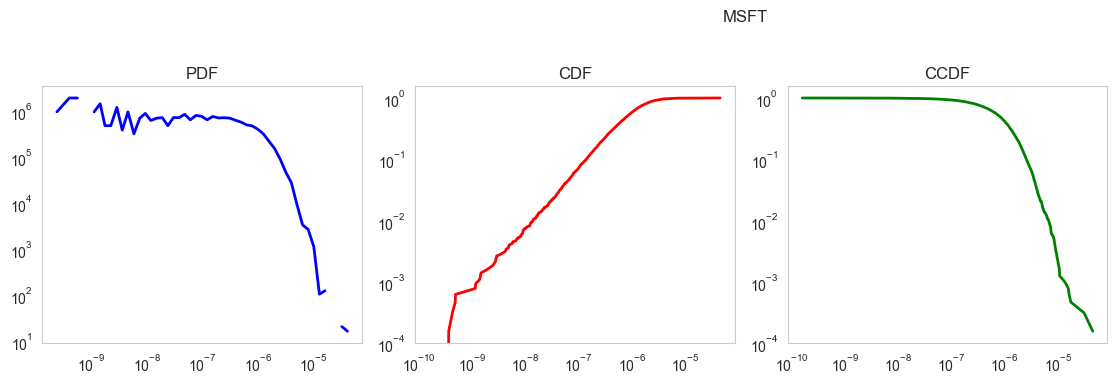

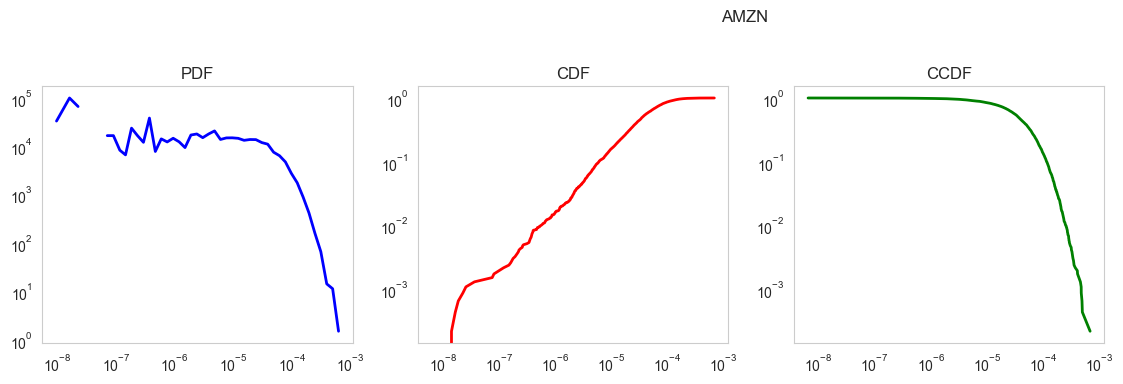

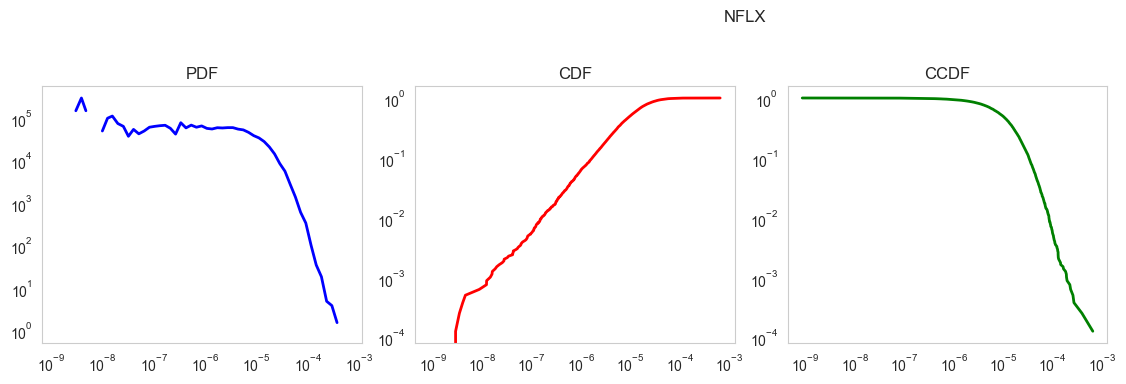

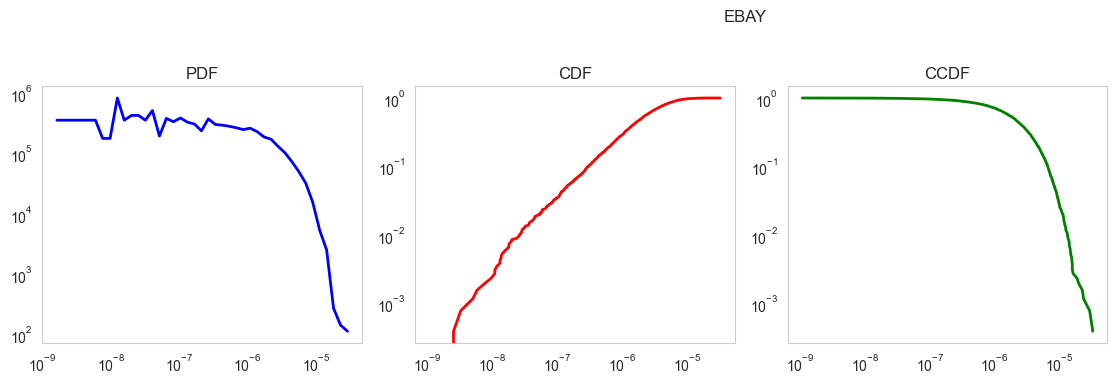

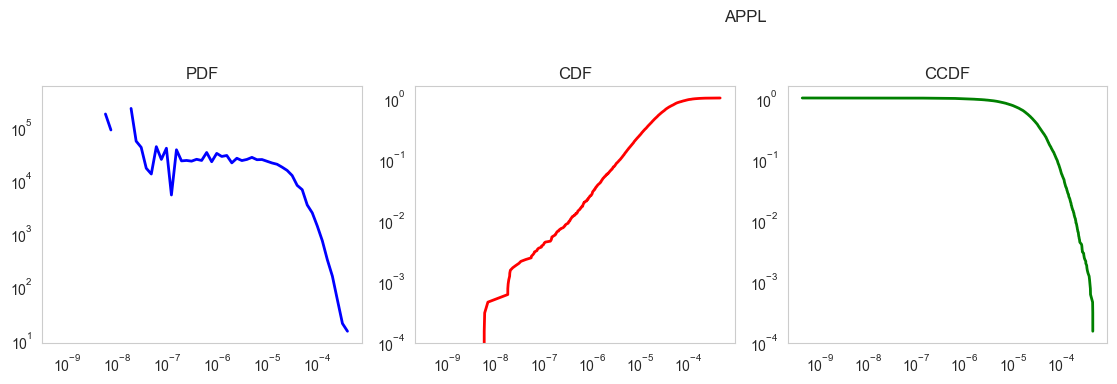

In [21]:
# Plot distribution of volume_imbalance for each stock
for stock_name, data in volume_imbalance.items():
    plot_distributions(stock_name, data)

#### 3.3.2 Fit power law distribution

In [22]:
# 1. Fit Powerlaw and retrieve fitted object/ results
volume_imbalance_data = os.path.join(root_dir, 'data', 'generated', 'mo_data', 'mo_volume_imbalance_distributions.pkl')

# If the file doesn't exist, fit the series and save the results.
if not os.path.exists(volume_imbalance_data):
    volume_imbalance_data_fit_objects = fit_powerlaw(volume_imbalance, volume_imbalance_data)
else:
    volume_imbalance_data_fit_objects = load_fit_objects(volume_imbalance_data)

volume_imbalance_data_fit_objects

{'TSLA': <powerlaw.Fit at 0x291906450>,
 'MSFT': <powerlaw.Fit at 0x16c349f90>,
 'AMZN': <powerlaw.Fit at 0x16c753650>,
 'NFLX': <powerlaw.Fit at 0x33540db10>,
 'EBAY': <powerlaw.Fit at 0x30b9b6810>,
 'APPL': <powerlaw.Fit at 0x2bd8cf350>}

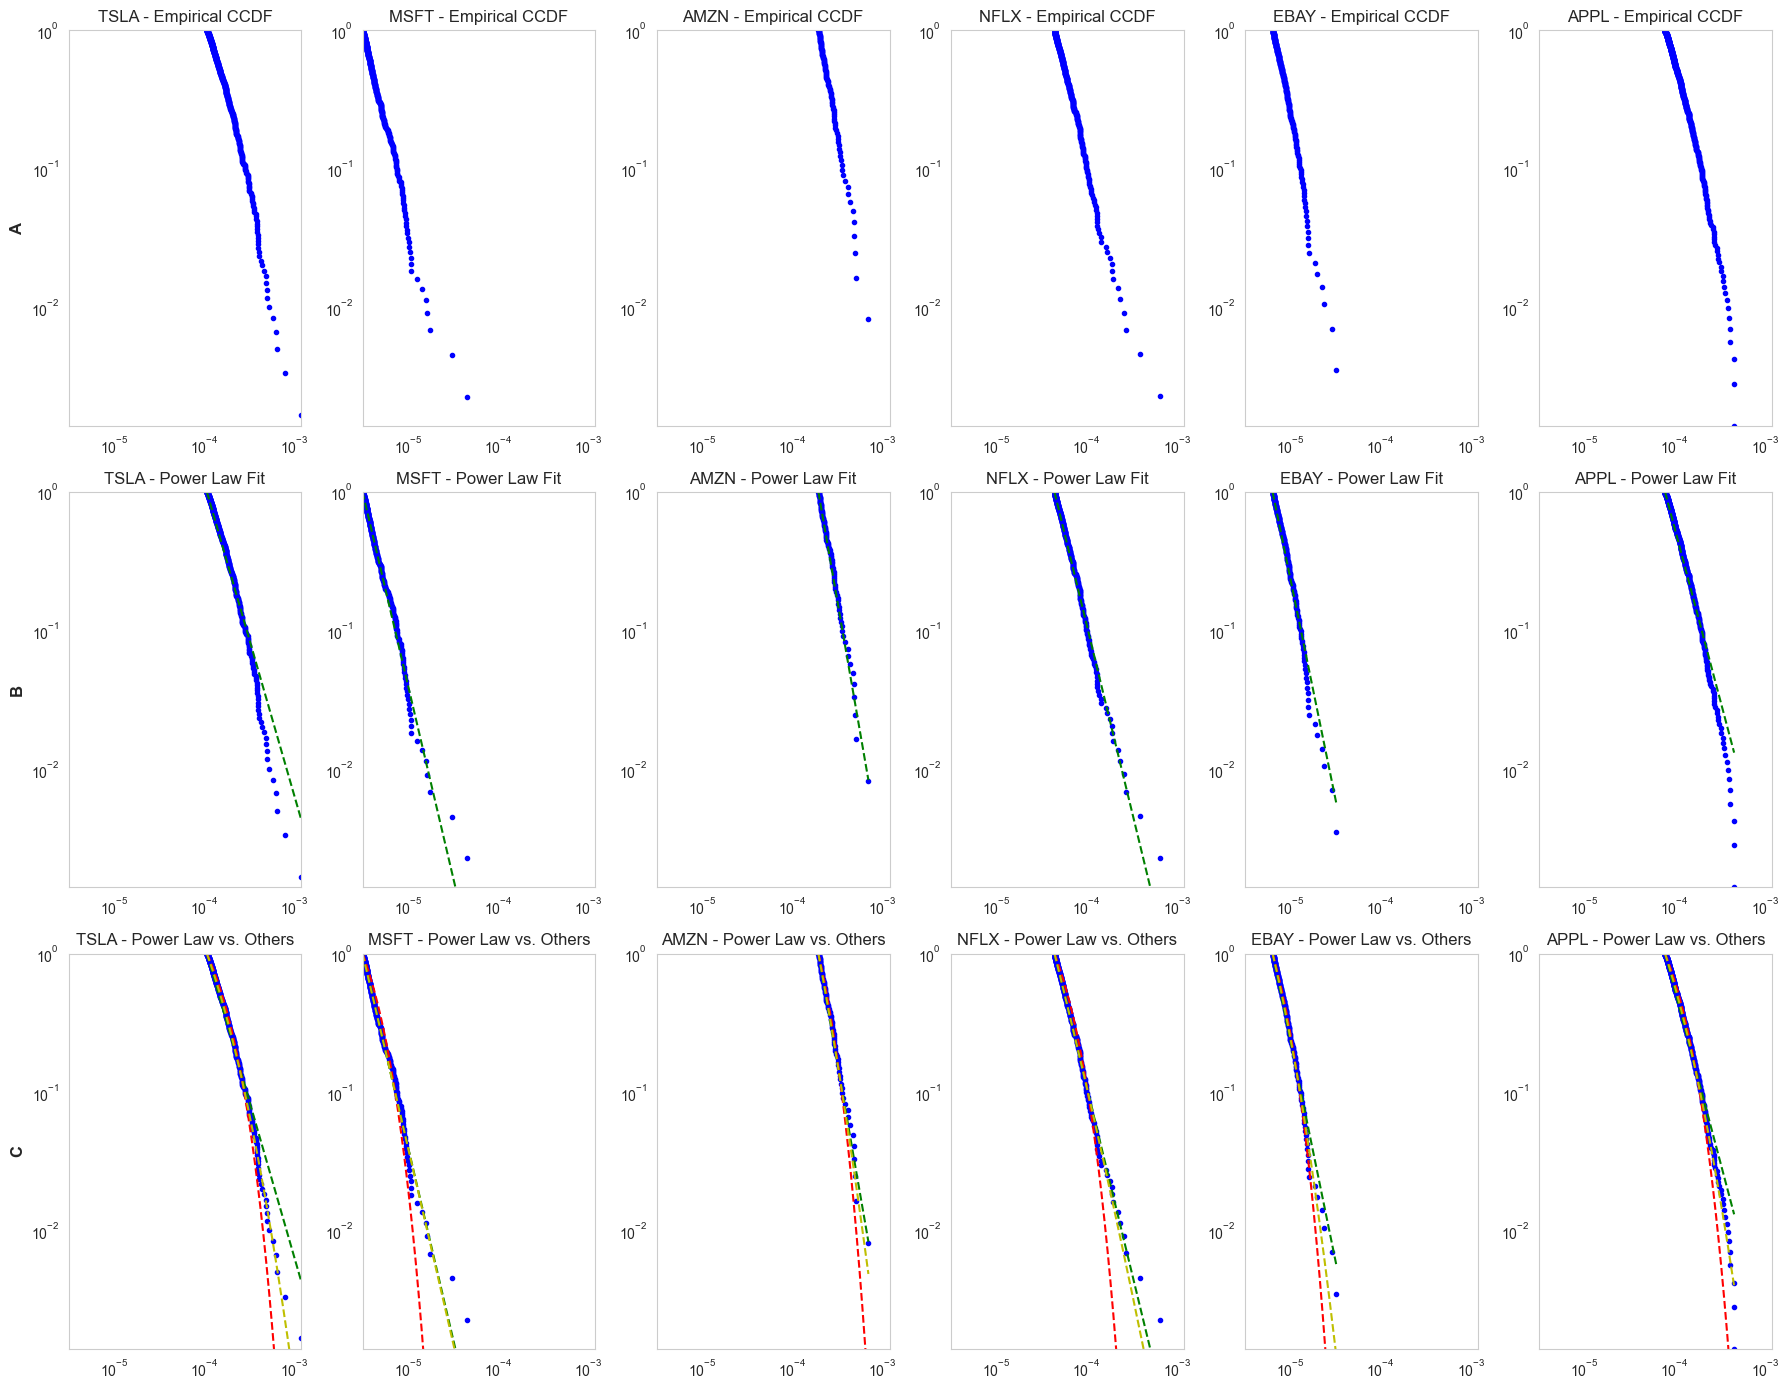

In [23]:
# Plot fitted objects
plot_fit_objects(volume_imbalance_data_fit_objects)

#### 3.3.2 Retrieve Power law fitting results

In [24]:
# Get fitting parameters for specific distribution across all stocks
volume_imbalance_fit_results = get_fitting_params(volume_imbalance_data_fit_objects, 'power_law')
print(volume_imbalance_fit_results)

  Stock Distribution     alpha      xmin  KS Distance
0  TSLA    power_law  3.260552  0.000107     0.047343
1  MSFT    power_law  3.771222  0.000003     0.029307
2  AMZN    power_law  4.750468  0.000195     0.045448
3  NFLX    power_law  3.686526  0.000044     0.025103
4  EBAY    power_law  4.179667  0.000006     0.048141
5  APPL    power_law  3.456765  0.000079     0.046415


In [25]:
# Average Alpha exponents across stocks
min_alpha = volume_imbalance_fit_results['alpha'].min()
max_alpha = volume_imbalance_fit_results['alpha'].max()
avg_alpha = volume_imbalance_fit_results['alpha'].mean()
std_dev_alpha = volume_imbalance_fit_results['alpha'].std()

print(f"Min Alpha: {min_alpha}")
print(f"Max Alpha: {max_alpha}")
print(f"Average Alpha: {avg_alpha}")
print(f"std_dev_alpha: {std_dev_alpha}")

Min Alpha: 3.260551770632118
Max Alpha: 4.750467774571268
Average Alpha: 3.8508666411901284
std_dev_alpha: 0.5393572075395177


#### 3.3.3 Compare alternative distributions

In [26]:
# Compare against alternative heavy-tailed distributions
from IPython.display import display
volume_imbalance_comparison = distribution_compare(volume_imbalance_data_fit_objects, 'exponential')
display(volume_imbalance_comparison)

,Stock,Alternative Distribution,Lambda,xmin,Power Law Alpha,KS Distance (Power Law),KS Distance (exponential),Loglikelihood Ratio,p-value
0,TSLA,exponential,13486.887523,0.000107,3.260552,0.047343,0.071000,0.248695,0.803597
1,MSFT,exponential,565314.932841,0.000003,3.771222,0.029307,0.129589,2.098662,0.035847
2,AMZN,exponential,14581.344889,0.000195,4.750468,0.045448,0.086580,0.618205,0.536440
3,NFLX,exponential,38769.406330,0.000044,3.686526,0.025103,0.106802,1.897879,0.057712
4,EBAY,exponential,362349.270214,0.000006,4.179667,0.048141,0.052249,0.140584,0.888198
5,APPL,exponential,20728.301345,0.000079,3.456765,0.046415,0.070010,0.344234,0.730670
